# **Forecasting Household Electricity Consumption in Singapore with SARIMA**

--- 


**Author:** Zachary Tang <br>
**Date published:** 9/1/21 <br>
<br>
**Contact information:**
- Email: zacharytangjiaying@gmail.com
- [Github](https://github.com/ZacharyTangJiaYing) 
- [Linkedin](https://www.linkedin.com/in/zacharytang/)

--- 


## **1. Introduction**
<a id='introduction'></a>

Forecasting household electricity consumption accurately could be very useful in policy design and resource planning. For policy makers, being able to forecast household electricity consumption can help them design more efficient and strategic ways to deliver electricity to households. For the engineers, it can help play in role in load analysis, planning and maintenance of the current power generation system. Forecasting can also help the private electricity providers plan for future investments and capability building. 

In this analysis, we will deploy a **SARIMA (Seasonal Autoregressive Moving Average) model** to forecast household electricity consumption in Singapore. The data we use is provided by Data.gov.sg. The model is developed and programmed in Python. 

## **2. Library**

In this analysis, we will be using the well known libraries for data analysis: NumPy, pandas, Matplotlib, seaborn, statsmodels and some functions from the scikit-learn library. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from scipy import stats
import datetime
import pmdarima as pm
import warnings 
import urllib
import requests
import json

%matplotlib inline

sns.set_theme()
sns.set_style('white')

## **3. Data Preprocessing**

### 3.1 Gathering the data

In this analysis, we will be using the [Total Household Electricity Consumption by Dwelling Type](https://data.gov.sg/dataset/total-household-electricity-consumption-by-dwelling-type) dataset from Gov Data. We first define a function that allows us to pull the latest dataset using Gov Data's API and load it into a pandas Dataframe.  

In [2]:
def get_data(dataset_id, limit):
    datagov_url = "https://data.gov.sg/api/action/datastore_search?resource_id="
    limit = "&limit={}".format(limit)
    url = datagov_url + dataset_id + limit
    response = requests.get(url)
    data = json.loads(response.text)
    df = pd.DataFrame.from_dict(data['result']['records'])
    return df

df = get_data('ea354e21-4b5f-450b-a63e-ca322fc7534e', 1000000) # Our dataset id in question is: ea354e21-4b5f-450b-a63e-ca322fc7534e

Here's a quick look at the raw dataset. We can see that our dataframe contains multiple time series, as represented by the columns. The frequency of observations is monthly.

In [3]:
df.head()

,landed_properties,private_housing,4-room,3-room,overall,month,public_housing,5-room_and_executive,others,_id,1-room_2-room,private_apts_and_condo
0,86.9,249.8,143.3,61.1,594.1,2019-01,343.4,127.4,0.8,1,11.5,163
1,89.1,256.7,148.5,62.3,613.6,2019-02,356,133.4,0.8,2,11.7,167.6
2,88.7,256.5,142,59.6,598.2,2019-03,340.9,128,0.8,3,11.2,167.8
3,94,277.6,155.9,66.2,653.1,2019-04,374.6,140.2,0.9,4,12.3,183.6
4,93.7,283.7,160.7,68.3,670.5,2019-05,385.9,144,0.9,5,12.8,190


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   landed_properties       187 non-null    object
 1   private_housing         187 non-null    object
 2   4-room                  187 non-null    object
 3   3-room                  187 non-null    object
 4   overall                 187 non-null    object
 5   month                   187 non-null    object
 6   public_housing          187 non-null    object
 7   5-room_and_executive    187 non-null    object
 8   others                  187 non-null    object
 9   _id                     187 non-null    int64 
 10  1-room_2-room           187 non-null    object
 11  private_apts_and_condo  187 non-null    object
dtypes: int64(1), object(11)
memory usage: 17.7+ KB


### 3.2 Data cleaning 

> #### 3.2.1 Create a datetime index for data

The raw data only provides us with the month in "YYYY-MM" string format in the "month" column. To make our analysis easier, we first create a new column name "date" by converting the month column values into a datetime objects, then set it as the index for our dataframe. We then set the frequency of our index to a monthly frequency.

In [5]:
df['date'] = [pd.to_datetime(x, format="%Y-%m") for x in df['month'].astype(str)] # Create a new column "date" with datetime objects

df = df.set_index(df['date']) # Set the column "date" as our index
df = df.sort_index() # Reorder our index according to date
df = df.asfreq("MS") # Set index frequency to monthly

> #### 3.2.2 Some data cleaning

In [6]:
df = df.drop(axis=1, columns=['month', 'date', '_id']) # Drop unneccessary columns

df = df.rename({'overall': "overall_gwh"}, axis=1) # Rename "overall" column to make things clearer

df = df.astype(np.float64) # Change the values to float

df['year'] = df.index.year # Add a new column with the year for our explaratory data analysis later in this notebook

Here's how our dataframe looks like now:

In [7]:
df.head()

,landed_properties,private_housing,4-room,3-room,overall_gwh,public_housing,5-room_and_executive,others,1-room_2-room,private_apts_and_condo,year
date,,,,,,,,,,,
2005-01-01,70.4,166.2,111.1,52.9,447.8,280.7,110.4,0.9,6.3,95.8,2005
2005-02-01,70.7,165.5,107.3,51.5,437.1,270.8,106.0,0.9,6.0,94.8,2005
2005-03-01,78.5,183.3,117.1,55.4,479.7,295.4,116.8,1.0,6.1,104.8,2005
2005-04-01,83.1,200.9,131.5,61.4,533.6,331.6,131.8,1.1,6.9,117.9,2005
2005-05-01,83.1,203.5,130.9,61.5,535.0,330.5,131.2,1.1,6.8,120.4,2005


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 2005-01-01 to 2020-07-01
Freq: MS
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   landed_properties       187 non-null    float64
 1   private_housing         187 non-null    float64
 2   4-room                  187 non-null    float64
 3   3-room                  187 non-null    float64
 4   overall_gwh             187 non-null    float64
 5   public_housing          187 non-null    float64
 6   5-room_and_executive    187 non-null    float64
 7   others                  187 non-null    float64
 8   1-room_2-room           187 non-null    float64
 9   private_apts_and_condo  187 non-null    float64
 10  year                    187 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 17.5 KB


In our dataframe: the columns represent the dwelling types along with aggregate columns for household total electricity consumption, total public housing electricity consumption, total private housing electicity consumptions and others. The rows represent the electricity consumption values for each category, measured in gigawatt hours (gwh). Our dataframe is indexed and ordered by the month, with the timeframe of Jan 2005 to July 2020.

## **4. Exploratory Data Analysis**

In this section, we explore and visualise the data to see if there are any interesting trends and patterns that could help us with our analysis and forecasting.

### 4.1 Decriptive statistics

In [9]:
df.drop(axis=1, columns='year').describe() # drop "year" column temporarily to take a look at the descriptive statistics of each category

,landed_properties,private_housing,4-room,3-room,overall_gwh,public_housing,5-room_and_executive,others,1-room_2-room,private_apts_and_condo
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,85.270588,227.499465,137.516043,61.706417,568.124599,339.652406,131.865775,0.972193,8.560963,142.231016
std,7.090979,33.238376,16.690254,5.810970,69.077311,36.751159,12.778081,0.137086,2.528212,26.868469
min,70.400000,165.500000,107.100000,50.400000,437.100000,270.800000,106.000000,0.600000,5.300000,94.800000
25%,80.600000,201.750000,126.400000,57.900000,518.850000,314.550000,123.300000,0.900000,6.400000,121.350000
50%,85.900000,225.900000,136.400000,61.500000,563.500000,337.800000,131.800000,1.000000,7.600000,138.600000
75%,90.000000,251.200000,148.350000,65.350000,612.550000,363.850000,139.500000,1.100000,10.700000,162.150000
max,113.700000,370.600000,215.200000,87.100000,886.700000,515.200000,194.800000,1.300000,18.100000,259.600000


As we can see, the dwelling types with high electricity consumption are condos, 4-room and 5-room HDB flats. This is not surprising given the fact that these are the most common dwelling types in Singapore. 

### 4.2 Line plot of overall electricity consumption

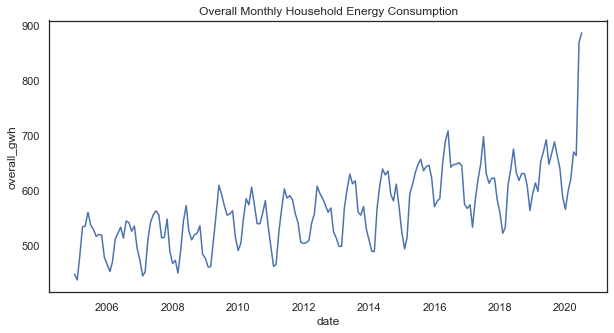

In [10]:
fig = plt.figure(figsize=(10,5))
plt.title("Overall Monthly Household Energy Consumption")
sns.lineplot(data=df, x='date', y='overall_gwh')
plt.show()

From the line plot, we can see that electricity consumption exhibits a seasonal pattern, which we will confirm later in the analysis. There is also a slight trend upwards throughout the years, due is could be due to the fact that there are simply more houses being built each year. <br>
<br>
Another interesting observation here is a large increase in electricity consumption in mid 2020. This could be explained by the fact that many companies are moving towards a work-from-home way of working due to the COVID pandemic, resulting in an increase of electricity usage.

### 4.3 Visualising the distribution

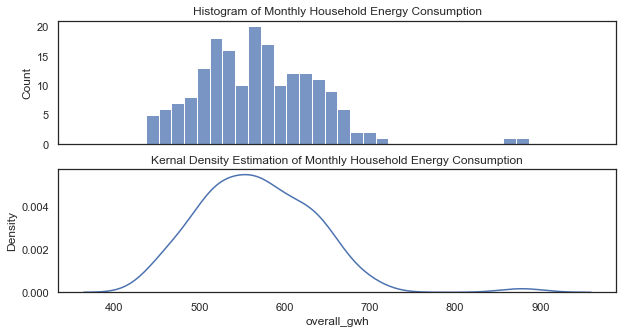

In [11]:
fig, ax = plt.subplots(2, figsize=(10,5), sharex=True)
sns.histplot(data=df, x='overall_gwh', bins=30, ax=ax[0])
sns.kdeplot(data=df, x='overall_gwh', ax=ax[1])
ax[0].set_title("Histogram of Monthly Household Energy Consumption")
ax[1].set_title("Kernal Density Estimation of Monthly Household Energy Consumption")
plt.show()

Next, we take a look at the distribution of monthly electicity consumption. Again, we see that there are two months where electricity use is abnormaly high, most likely due to the COVID pandemic. Another point of observation here is that monthly electricity usage looks like its normally distributed, but since we're dealing with time series data, we should factor in the intertemporal order in our visualisation using a boxplot.

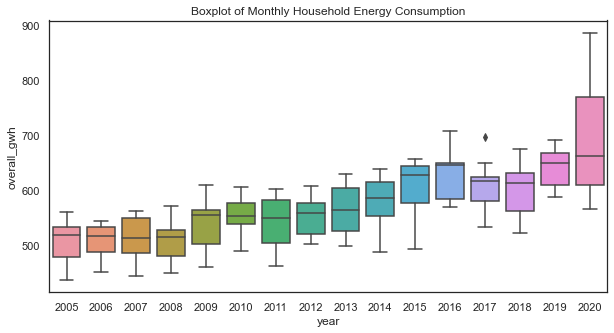

In [12]:
fig = plt.figure(figsize=(10,5))
plt.title("Boxplot of Monthly Household Energy Consumption")
sns.boxplot(x=df['year'], y=df['overall_gwh'])
plt.show()

In this boxplot, we can see that the distribution of monthly electricity is relatively stable from year to year, excluding 2020. An interesting observation is that we see electricity use go down slightly in 2017-2018 from the previous years. The reason for the observation is not entirely clear without looking at other factors that could affect electricity usage such as the temperature.

### 4.4 Visualizing the data by dwelling type

Let's further explore the data by visualling according to the dwelling type.

> #### 4.4.1 Creating a temp dataframe

First, we create a temporary dataframe to convert the original dataframe from a wide format to a long one.

In [13]:
temp_df = df.drop(axis=1, columns=['overall_gwh','public_housing', 'private_housing', 'year']) # Drop aggregate columns

temp_df = temp_df.stack().reset_index().set_index('date') # Stack the category columns, then reset the index and set it to date again

temp_df = temp_df.rename({temp_df.columns[0]: 'type_of_house', temp_df.columns[1]:'gwh'},axis=1) # Rename the columns

Here's a look at our temp dataframe: 

In [14]:
temp_df.head()

,type_of_house,gwh
date,,
2005-01-01,landed_properties,70.4
2005-01-01,4-room,111.1
2005-01-01,3-room,52.9
2005-01-01,5-room_and_executive,110.4
2005-01-01,others,0.9


In [15]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1309 entries, 2005-01-01 to 2020-07-01
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   type_of_house  1309 non-null   object 
 1   gwh            1309 non-null   float64
dtypes: float64(1), object(1)
memory usage: 30.7+ KB


> #### 4.4.2 Line plot by dwelling type

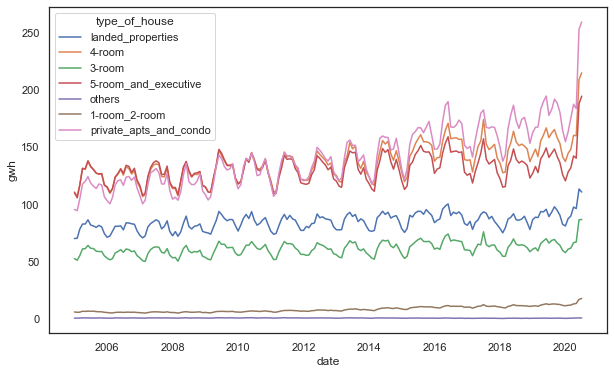

In [16]:
fig = plt.figure(figsize=(10,6))
sns.lineplot(x=temp_df.index, y=temp_df['gwh'], hue=temp_df['type_of_house'])
plt.show()

In this line plot, we can observe that the seasonal patterns are more pronouced for 4-room, 5-room and private apartments/condos. We also observe that seemingly upward trend in electricity use is driven 4-room flats and private apartments/condos. The reason for growth in electricity usage in these two dwellings could be due to the fact that there these are built more often then the other dwelling types. <br> 
<br>
The jump in electricity use in the mid 2020s is also more pronouced for private apartments and condos. A potential reason for this could be that those who stay in apartments and condos are usually office workers who are mostly able to work from home during the pandemic<br>
<br>
On the other hand, we observe that electricity consumption in landed properties, 3-room flats, 1-2room flats are relatively stable over time, again, possibly because these dwelling types are not being built as quickly as the others. 

> #### 4.4.3 Histogram by dwelling type

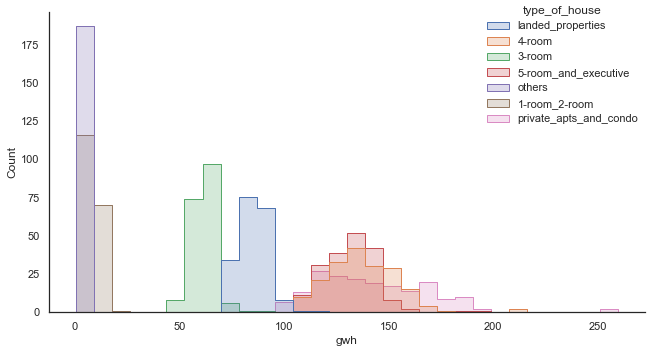

In [17]:
fig = sns.displot(temp_df, x='gwh', bins=30, hue='type_of_house', element="step", legend=True)
fig.fig.set_size_inches(15,5)
fig._legend.set_bbox_to_anchor((0.6,0.8)) # Change legend location
plt.show()

The histogram above confirms our suspicion that the variation of electricity use in 4-room, 5-room and private apartments/condos is larger compared to the other dwelling types. 

## **5. Model Specification**

Our goal to this analysis is to develop a model that can **accurately forecast household electricity consumption in Singapore**. For this purpose, we will only be concered with the overall electricity consumption, as captured in the "overall_gwh" column of our dataframe.<br>
- **Dependant variable *y*** = monthly overall household electricity consumption in Singapore measured by gigawatt hours (gwh)

We will attempt to model the data using a **SARIMA (Seasonal autoregressive integrated moving average) model**. The SARIMA model is one of the most common approaches used in time series forecasting. The model essentially uses the past values of the dependant variable and the past errors to predict future values. <br>
<br>
To fit our model, we must first identify the follow hyperparameters:
- **p** - number of lag autoregressive terms
- **d** - number of differencing needed to acheive stationarity
- **q** - number of lag moving average terms
- **P** - number of seasonal lag autoregressive terms
- **D** - number of seasonal differencing to remove trends in seasonality
- **Q** - number of seasonal lag moving average terms

Overall, our model will be specified as such: **SARIMA (p,d,q) x (P,D,Q)m**<br>
- where **m** represents the period of seasonality

### 5.1 Identification strategy

Our overall strategy for identifying an adequate model to forecast electricity consumption is as follows: <br>
1. **Check and ensure that our time series data is stationary**
    - To model the data, we must ensure that the series is at least weakly stationary, meaning the series mean, variance and covariance between two points do not depend on time. If the series is not stationary, modelling and forecasting the data would not be very useful as its statistical properties change over time.
    - **Statistical tests:** Augmented Dickey Fuller test
<br>
<br>
2. **Study the autocorrelation (ACF) and partial autocorrelation functions (PACF) to gain insight**
    - A visual inspection of the ACF and PACF plots can help us identify the type of model and the orders of the model. <br>
<br>
3. **Decompose the time series**
    - By decomposing the time series, we can study the individual components and check if there exists a trend and seasonal pattern in the series
    - **Decomposition method:** Seasonal and Trend decomposition using Loess (STL)<br>
<br>
4. **Identify two models:** one that minimizes the Aikeke Information Criteria (AIC) and one that gives use the best forecast measured by the root mean squared error of forecasts (RMSE)
    - We will use the auto_arima function from the pmdarima library to perform a grid search of a number of models to indentify the model with the lowest AIC, representing a parsimonous model
    - We will then code a grid search algorithm to find the model with the lowest RMSE for forecasts<br>
<br>


### 5.2 Train, test split

**Ultimately, our goal is to develop a model that gives us the most accurate forecasts.** To do so, we must have a way to evaluate our forecasts. A common practice in time series analysis is to split our data into two portions: **training (in-sample)** and **test (out-of-sample)** data. <br>
<br>The training data will be used to estimate and fit our model, while the test data will be used to evaluate the model's forecast accuracy (more on forecast evaluation later). Because the test data is not used in fitting the model, it should provide a indication of how well our model is able to forecast.<br>
<br> For time series, our split must be ordered according to time. Hence we will set our test data to be **20% of the total sample** or the **last 37 observations**.

> #### 5.2.1 Splitting the data

In [18]:
# Train Test Split Function

def train_test_split(series, test_size):
    train = series[:-test_size]
    test = series[-test_size:]
    return train, test

train, test = train_test_split(df, 37) # Set test size as 37 observations

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 150 entries, 2005-01-01 to 2017-06-01
Freq: MS
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   landed_properties       150 non-null    float64
 1   private_housing         150 non-null    float64
 2   4-room                  150 non-null    float64
 3   3-room                  150 non-null    float64
 4   overall_gwh             150 non-null    float64
 5   public_housing          150 non-null    float64
 6   5-room_and_executive    150 non-null    float64
 7   others                  150 non-null    float64
 8   1-room_2-room           150 non-null    float64
 9   private_apts_and_condo  150 non-null    float64
 10  year                    150 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 14.1 KB


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37 entries, 2017-07-01 to 2020-07-01
Freq: MS
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   landed_properties       37 non-null     float64
 1   private_housing         37 non-null     float64
 2   4-room                  37 non-null     float64
 3   3-room                  37 non-null     float64
 4   overall_gwh             37 non-null     float64
 5   public_housing          37 non-null     float64
 6   5-room_and_executive    37 non-null     float64
 7   others                  37 non-null     float64
 8   1-room_2-room           37 non-null     float64
 9   private_apts_and_condo  37 non-null     float64
 10  year                    37 non-null     int64  
dtypes: float64(10), int64(1)
memory usage: 3.5 KB


> #### 5.2.2 Visualizing the split

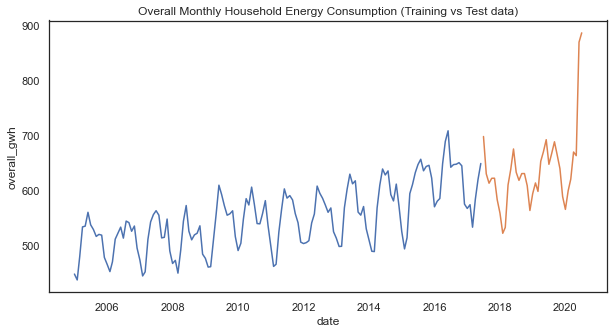

In [21]:
fig = plt.figure(figsize=(10,5))
plt.title("Overall Monthly Household Energy Consumption (Training vs Test data)")
sns.lineplot(data=train, x='date', y='overall_gwh')
sns.lineplot(data=test, x='date', y='overall_gwh')
plt.show()

### 5.3 Stationarity

As mentioned, we require our time series to be stationary for the purposes of producing reliable forecast. If there is any trend and seasonaility in the underlying time series, our time series will not be stationary.

> #### 5.3.1 Augmented Dickey Fuller Test

Here, we use the Augmented Dickey Fuller test (ADF) for stationarity to test our training data set. The ADF test will allow us to check the time series for the existance of a unit root, which essentially indicates non-stationarity. <br>
<br>
The hypothesis of the ADF test are as follows:
<center>H0: Unit root</center><br>
<center>H1: No unit root</center><br>

In [22]:
# Augmented dickey fuller test for stationarity

adf_results = adfuller(train['overall_gwh'])
print('ADF Statistic: {0[0]:.3f} \nP-value: {0[1]:.3f} \nObservations: {0[3]}'.format(adf_results))

ADF Statistic: -1.005 
P-value: 0.751 
Observations: 135


As we can see, the **p-value (0.751)** of the ADF statistic is way above the significance levels of 10%, 5% and 1%. This result means we fail to reject the null hypothesis and find that there is evidence suggesting that our training data is non-stationary. 

> #### 5.3.2 Autocorrelation and Partial Autocorrelation Plots

To further check our hypothesis that our training data set is non-stationary, we plot the autocorrelation and partial autocorrelation functions. <br>
<br>
**Autocorrelation:** The correlation between the variable at time t and past lags of the variable<br>
**Partial autocorrelation:** The correlation between the variable at time t and the past lag of the variable while holding all intermediate lags constant<br>
<br>
Studying the plots may also give us some indication of the underlying orders **p** and **q** of our SARIMA model. A summary of the behavior of the ACF and PACF is as follows:

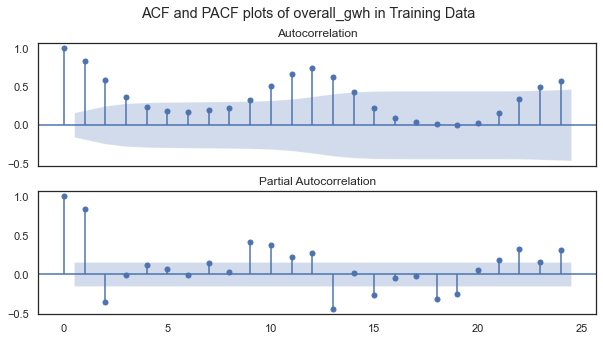

In [23]:
# Plot ACF and PACF plots of the training data

fig, ax = plt.subplots(2, figsize=(10,5), sharex=True)
fig.suptitle("ACF and PACF plots of overall_gwh in Training Data")
plot_acf(train['overall_gwh'], ax=ax[0], lags=24)
plot_pacf(train['overall_gwh'], ax=ax[1], lags=24)
plt.show()

As seen in the plots, the ACF decays somewhat slowly and there is **significant correlation** in around the 10-14 month lags, giving us a signal that seasonality exists in the time series. The PACF also gives us an indication of seasonality.

> #### 5.3.3 Differencing

A common approach to make a non-stationary series stationary is to compute the differences between observations, this is know as differencing. Here, we will take the first difference of the overall_gwh variable in our training data and call the differenced series **overall_gwh.d1**

In [24]:
# Take  the first difference

train['overall_gwh.d1'] = train['overall_gwh'] - train['overall_gwh'].shift(1)

<ipython-input-24-0f3d906d2387>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['overall_gwh.d1'] = train['overall_gwh'] - train['overall_gwh'].shift(1)


Here's a lineplot of our differenced series:

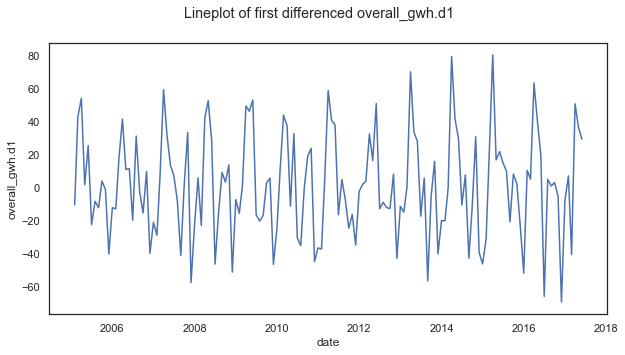

In [25]:
fig = plt.figure(figsize=(10,5))
sns.lineplot(x=train.index, y=train['overall_gwh.d1'])
fig.suptitle("Lineplot of first differenced overall_gwh.d1")
plt.show()

We can see from the line plot that the trend is largely removed. There are still some noticable spikes that occur periodically, which tells us that seasonality still exists in our series, hence we also take the seaonsal difference of our differenced data and call the variable **overall_gwh.D1**.

In [26]:
# Take seasonal difference of first difference

train['overall_gwh.D1'] = train['overall_gwh.d1'] - train['overall_gwh.d1'].shift(12)

<ipython-input-26-ec742f88e3e7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['overall_gwh.D1'] = train['overall_gwh.d1'] - train['overall_gwh.d1'].shift(12)


Here's how the variable overall_gwh.D1 looks:

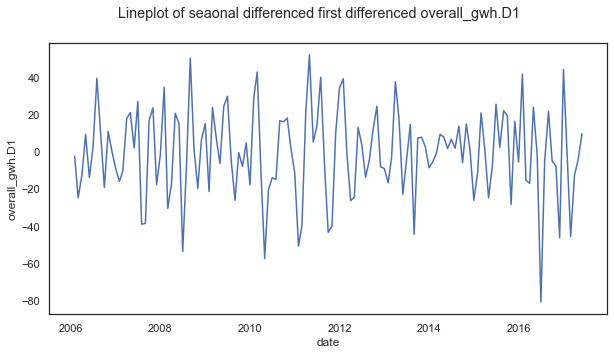

In [27]:
fig = plt.figure(figsize=(10,5))
sns.lineplot(x=train.index, y=train['overall_gwh.D1'])
fig.suptitle("Lineplot of seaonal differenced first differenced overall_gwh.D1")
plt.show()

Now, let's test if the differenced series is stationary using the ADF test:

In [28]:
# Test seasonally differenced first difference series for stationarity

adf_results = adfuller(train['overall_gwh.D1'].dropna())
print('ADF Statistic: {0[0]:.3f} \nP-value: {0[1]:.3f} \nObservations: {0[3]}'.format(adf_results))

ADF Statistic: -4.159 
P-value: 0.001 
Observations: 123


The **p-value (0.001)** of the ADF statistic is below the significance levels of 10%, 5% and 1%. We conclude that the series is stationary.

Checking the ACF and PACF plots again:

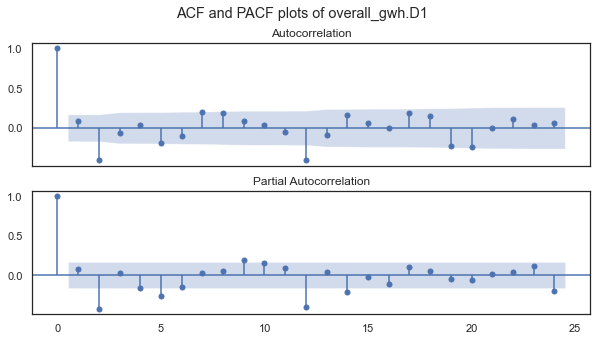

In [29]:
# ACF and PACF of first and seasonally differenced series

fig, ax = plt.subplots(2, figsize=(10,5), sharex=True)
fig.suptitle("ACF and PACF plots of overall_gwh.D1")
plot_acf(train['overall_gwh.D1'].dropna(), ax=ax[0], lags=24)
plot_pacf(train['overall_gwh.D1'].dropna(), ax=ax[1], lags=24)
plt.show()

We see that there are very significant lags in the ACF and PACF plots at lag=2 and lag=12. We could perhaps entertain a **SARIMA (2,1,2) x (1,1,1) model** from the plots.

For now, we will use the variable **overall_gwh.D1** which is the original variable **overall_gwh** with an order **d = 1** and order **D = 1**, which represents the seasonal differenced first differenced series. 

### 5.4 Time series decomposition

It may be helpful to decompose our training data into the trending and seasonal components to confirm our suspicions that there exist non-stationary patterns in our series. We use the **Seasonal and Trend decomposition using Loess (STL)** method, which is thankfully built into statsmodels, to decompose our data. 

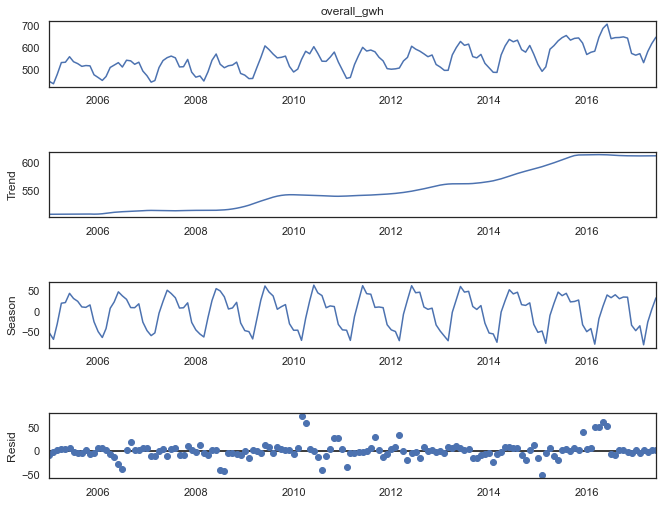

In [30]:
# Time series decomposition using Loess

stl = STL(train['overall_gwh'], robust=True).fit()
fig = stl.plot()
fig.set_size_inches(10, 8)

As we can see, there exist quite a strong trend and 12 month seasonality in our training data. The residuals of the decomposition also look like its close to 0, signalling that most of the trending and seasonal components have been extracted from the time series. <br>
<br>
We are therefore reassured that to model and forecast household electricity consumption accurately, we would need to set **d=1** and **D=1** to acheive stationarity.

### 5.5 AutoARIMA and the RMSE model

Now, let us use a grid search algorithm to specify two additional models to compare along with our hypothesized SARIMA (2,1,2) x (1,1,1) model. Often times it is good practice to identify several models in the model identification stage, evaluate the adequacy of each model and choose the best one.

**Model 2: Model that minimizes the AICc (Parsimonous model)**
- The AICc (or Corrected Aikaike's Information Criteria) is useful in selecting predictors for ARIMA models, namely the *p*, *q*, *P* and *Q* orders. 
- The AICc penalizes the addition of more parameters in the model, hence a parsimonous model would be one that minimizes the criterion
- We will utilize the **auto_arima function** from the pmdarima library to help us find the model that minimizes the AICc

**Model 3: Model that minimizes the RMSE**
- The goal of this model is to identify the orders that give us the most accurate forecasts
- The RMSE (or root mean squared error) is a scale-dependant forecast evaluation measure commonly used to compare forecast methods on a single time series. The RMSE penalizes higher forecast errors compared to smaller errors, making it a stringent forecast evaluation measure
- We will define our own algorithm to help us locate the model with the lowest RMSE

> #### 5.4.1 Parsimonous model (minimize AICc)

For information about the parameters and arguements for this AutoARIMA function, you can read the official documentation [here](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html#).

In [31]:
# Use AutoARIMA to identify the most parsimonous model via grid search

model_par = pm.auto_arima(train['overall_gwh'], start_p=0, d=1, start_q=0, max_p=3, max_q=3, start_P=0, seasonal=True, D=1, start_Q=0, max_P=3, max_Q=3, m=12,
                              trace=True, error_action='ignore', suppress_warnings=True, stepwise=False, information_criterion='aicc')

 ARIMA(0,1,0)(0,1,0)[12]             : AICC=1254.994, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AICC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AICC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AICC=inf, Time=0.99 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AICC=1227.000, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AICC=inf, Time=0.23 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AICC=inf, Time=0.46 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AICC=inf, Time=1.54 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AICC=1223.519, Time=0.11 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AICC=inf, Time=0.47 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AICC=inf, Time=0.79 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AICC=inf, Time=1.81 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AICC=1216.740, Time=0.25 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AICC=inf, Time=1.02 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AICC=inf, Time=1.84 sec
 ARIMA(0,1,1)(0,1,0)[12]           

**Parameters set:** 
- Max *p* order at 3
- Max *q* order at 3
- Max *P* order at 3
- Max *Q* order at 3
- *d* set at 1
- *D* set at 1

As you can see, the AutoARIMA function estimates several iterations of SARIMA models in a stepwise algorithm to look for the model that minimizes the AICc. We finally land on the model **SARIMA (0,1,3) x (0,1,1) with the lowest AICc at 1170.254**.

> #### 5.4.2 RMSE Model

To estimate the RMSE model, we must first establish how the forecasts are estimated. In time series validation with training and test data (like ours), it is common to evaluate a one-step forecast ahead of the last observation in the training set, record the forecast, then add the actual value from the test set into the training set to evaluate the next step ahead forecast. RMSE will then be evaluated by averaging over the test set and the recoreded forecasts. This procedure is known as the **expanding window forecasting**. For more information, you can read the chapter from [Rob Hyndman's book "Forecasting Principles and Practice"](https://otexts.com/fpp2/accuracy.html).

A useful diagram to visual the expanding window forecasting procedure from the book: 
- Blue dots represents the actual observations from the training data set
- Grey dots represents the actual observations from the test data set
- Red dots represents the one step ahead forecasts (out-of-sample) from the training data set

In [32]:
from IPython.display import Image
from IPython.core.display import HTML 

In [33]:
Image(url= "https://otexts.com/fpp2/fpp_files/figure-html/cv1-1.png", width=1000, height=500)

Now, we will create and run an algorithm that estimates several iterations of the SARIMA model and record its RMSE value:

In [34]:
# Model Selection Algorithm based on RMSE (expanding window)

def evaluate_SARIMA_model(series, arima_order, seasonal_order): # series = time series, 
# arima_order = tuple of (p,d,q), seasonal_order = tuple of (P,D,Q)

    history = [x for x in series] # create a list for our expanding training set
    predictions = [] # create a list to record all one-step-ahead forecasts
    
    for t in range(len(test)): # loop over the number of observations in the training data set
        model = SARIMAX(history, order=arima_order, seasonal_order=seasonal_order) 
        # use the SARIMAX function from statmodels to estimate the model with our 
        # expanding training data set
        model_fit_rmse = model.fit() # fit the model 
        yhat = model_fit_rmse.forecast() # generate a one-step-ahead forecast
        history.append(test['overall_gwh'][t]) 
        # append the next actual observation from the test set into the training set
        predictions.append(yhat) # record our forecast 
        
    rmse = np.sqrt(mean_squared_error(test['overall_gwh'],predictions)) # evaluate the RMSE
    return rmse

def evaluate_models(dataset, p_values, d_values, q_values, P_values, D_values, Q_values): 
# function to iterate over several p,d,q,P,D,Q values

    dataset = dataset.astype('float32') # convert our time series values into float
    
    best_score, best_cfg, best_s_cfg = float("inf"), None, None 
    # initate variables to hold our best RMSE score, best arima order and best seasonal orders

    for p in p_values: # iterate over our p values
        for q in q_values: # iterate over our q values
            for P in P_values: # iterate over our P values
                for Q in Q_values: # iterate over our Q values
                    
                    m = 12 # set period as 12, for monthly data
                    order = (p,d_values,q)
                    s_order = (P,D_values,Q,m)
                    
                    try:
                        rmse = evaluate_SARIMA_model(dataset, order, s_order) 
                        # fit the model using the function above and return the RMSE
                        
                        if rmse < best_score: 
                        # update and store if the RMSE in this interation is lower than the previous
                            best_score, best_cfg, best_s_cfg = rmse, order, s_order
                        print('ARIMA{0}{1} RMSE={2}'.format(order,s_order,rmse))

                    except:
                        continue
                        
    print('Best ARIMA{0}{1} RMSE={2}'.format(best_cfg, best_s_cfg, best_score))

p_values = [0,1,2,3] # range of p values to iterate over
q_values = [0,1,2,3] # range of q values to iterate over
P_values = [1,2] # range of P values to iterate over (shorterned to reduce time)
Q_values = [1,2] # range of Q values to iterate over (shorterned to reduce time)

warnings.filterwarnings("ignore")

evaluate_models(train['overall_gwh'], p_values, 1, q_values, P_values, 1, Q_values) # run the algorithm

ARIMA(0, 1, 0)(1, 1, 1, 12) RMSE=39.77449798297145
ARIMA(0, 1, 0)(1, 1, 2, 12) RMSE=39.97936365120938
ARIMA(0, 1, 0)(2, 1, 1, 12) RMSE=39.99135415986524
ARIMA(0, 1, 0)(2, 1, 2, 12) RMSE=40.167991485580785
ARIMA(0, 1, 1)(1, 1, 1, 12) RMSE=44.16029367720322
ARIMA(0, 1, 1)(1, 1, 2, 12) RMSE=44.553425966906524
ARIMA(0, 1, 1)(2, 1, 1, 12) RMSE=44.413441762758424
ARIMA(0, 1, 1)(2, 1, 2, 12) RMSE=44.66692902762671
ARIMA(0, 1, 2)(1, 1, 1, 12) RMSE=39.176728025792535
ARIMA(0, 1, 2)(1, 1, 2, 12) RMSE=39.46691200727969
ARIMA(0, 1, 2)(2, 1, 1, 12) RMSE=39.267827874070754
ARIMA(0, 1, 2)(2, 1, 2, 12) RMSE=39.45207284571673
ARIMA(0, 1, 3)(1, 1, 1, 12) RMSE=39.71548270723593
ARIMA(0, 1, 3)(1, 1, 2, 12) RMSE=40.2010206352852
ARIMA(0, 1, 3)(2, 1, 1, 12) RMSE=39.882444682774796
ARIMA(0, 1, 3)(2, 1, 2, 12) RMSE=40.169811427766184
ARIMA(1, 1, 0)(1, 1, 1, 12) RMSE=40.42190227147272
ARIMA(1, 1, 0)(1, 1, 2, 12) RMSE=40.572960005549035
ARIMA(1, 1, 0)(2, 1, 1, 12) RMSE=40.6444439495361
ARIMA(1, 1, 0)(2, 1, 2, 1

**Important note:** We reduced the seasonality orders P, Q compared to the AutoARIMA function to reduce computation time. 

From our algorithm, we identified the model **SARIMA (3,1,0) x (1,1,1) that produces the lowest RMSE score of 38.574**

## **6. Model Estimation**

So far, we have identified 3 potential models:
- **Model 1 (model_hyp): SARIMA (2,1,2) x (1,1,1)** - model specified from acf and pacf plots
- **Model 2 (model_par): SARIMA (0,1,3) x (0,1,1)** - model that minimizes the AICc
- **Model 3 (model_rmse): SARIMA (3,1,0) x (1,1,1)** - model that minimizes RMSE

Let us know fit the models using the SARIMAX function in the statsmodels library and print the summary.

### 6.1 Model 1 (model_hyp): SARIMA (2,1,2) x (1,1,1)

In [35]:
model_hyp = SARIMAX(train['overall_gwh'], order=(2,1,2), seasonal_order=(1,1,1,12))
model_hyp = model_hyp.fit()
model_hyp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          overall_gwh   No. Observations:                  150
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -579.488
Date:                              Sun, 10 Jan 2021   AIC                           1172.976
Time:                                      00:03:48   BIC                           1193.416
Sample:                                  01-01-2005   HQIC                          1181.283
                                       - 06-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2347      0.214      1.095      0.274      -0.185       0.655
ar.L2         -0.2524      0.189     -1.339      0.181      -0.622       0.117
ma.L1         -0.2611      0.182     -1.431      0.153      -0.619       0.097
ma.L2         -0.2903      0.178     -1.635      0.102      -0.638       0.058
ar.S.L12      -0.0751      0.155     -0.484      0.629      -0.379       0.229
ma.S.L12      -0.8046      0.133     -6.061      0.000      -1.065      -0.544
sigma2       248.3855     32.559      7.629      0.000     184.572     312.199
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 4.08
Prob(Q):                              0.90   Prob(JB):                         0.13
Heteroskedasticity (H):               1.84   Skew:                            -0.32
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6.2 Model 2 (model_par): SARIMA (0,1,3) x (0,1,1)

In [36]:
model_par = SARIMAX(train['overall_gwh'], order=(0,1,3), seasonal_order=(0,1,1,12))
model_par = model_par.fit()
model_par.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          overall_gwh   No. Observations:                  150
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -579.919
Date:                              Sun, 10 Jan 2021   AIC                           1169.837
Time:                                      00:03:49   BIC                           1184.437
Sample:                                  01-01-2005   HQIC                          1175.770
                                       - 06-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0116      0.097      0.120      0.904      -0.178       0.201
ma.L2         -0.4979      0.067     -7.469      0.000      -0.629      -0.367
ma.L3         -0.1938      0.097     -2.002      0.045      -0.384      -0.004
ma.S.L12      -0.8636      0.097     -8.931      0.000      -1.053      -0.674
sigma2       245.4327     30.169      8.135      0.000     186.303     304.562
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 4.43
Prob(Q):                              0.74   Prob(JB):                         0.11
Heteroskedasticity (H):               1.84   Skew:                            -0.31
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6.3 Model 3 (model_rmse): SARIMA (3,1,0) x (1,1,1)

In [37]:
model_rmse = SARIMAX(train['overall_gwh'], order=(3,1,0), seasonal_order=(1,1,1,12))
model_rmse = model_rmse.fit()
model_rmse.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          overall_gwh   No. Observations:                  150
Model:             SARIMAX(3, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -581.374
Date:                              Sun, 10 Jan 2021   AIC                           1174.748
Time:                                      00:03:49   BIC                           1192.268
Sample:                                  01-01-2005   HQIC                          1181.868
                                       - 06-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0202      0.097      0.209      0.835      -0.170       0.210
ar.L2         -0.4767      0.085     -5.584      0.000      -0.644      -0.309
ar.L3         -0.0383      0.089     -0.430      0.667      -0.213       0.137
ar.S.L12      -0.0850      0.145     -0.584      0.559      -0.370       0.200
ma.S.L12      -0.8153      0.139     -5.858      0.000      -1.088      -0.542
sigma2       254.1996     35.618      7.137      0.000     184.389     324.010
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.00
Prob(Q):                              1.00   Prob(JB):                         0.05
Heteroskedasticity (H):               1.69   Skew:                            -0.44
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **7. Model Diagnostics** 

Now that we have estimated and fitted our 3 models, let us evaluate the adequacy of each model. We first start off by plotting the diagnostic diagrams for each model using the **plot_diagnostics method** found in the statsmodels library.

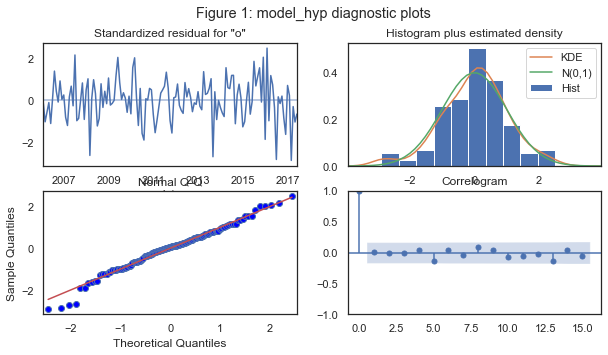

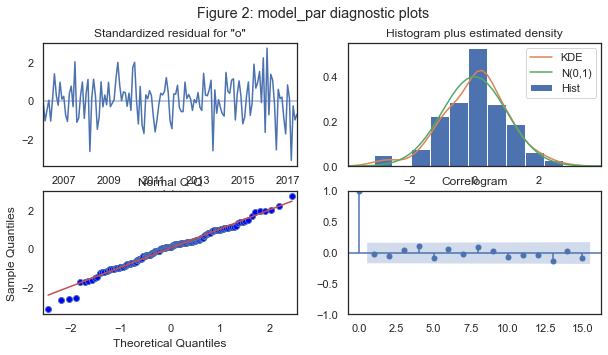

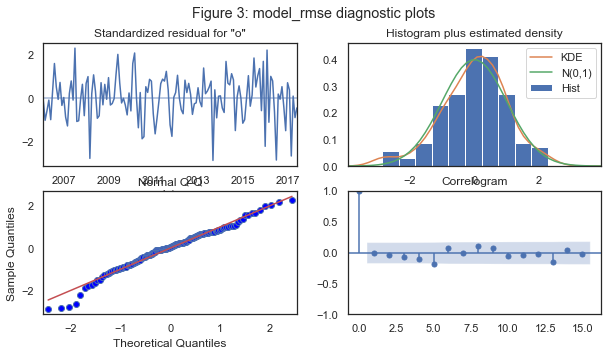

In [38]:
models = {'model_hyp':model_hyp, 'model_par':model_par, 'model_rmse':model_rmse}
fig_count = 1

for k,v in models.items():
    fig = v.plot_diagnostics(lags = 15, figsize=(10,5))
    fig.suptitle("Figure " + str(fig_count) + ": " + k + " diagnostic plots")
    fig_count += 1
    plt.show()

### 7.1 Residual Analysis

Residuals in a time series model refers to what is left over after fitting a model to the data. Residual analysis is useful in checking if our fitted model has adequately captured all information from the time series. 

A adequate model has **serially uncorrelated and normally distributed residuals, resembling white noise**. We can check this by visually studying the diagnostic plots above and performing some statistical tests. Let us know go through the residual analysis step by step.

> #### 7.1.1 Standardized residuals plot

The standardized residual plot allows us to visualize our residuals and check for any noticeable patterns and trends. The residuals are standardized to help us see residuals of unusual size properly. If a model is adquate, **we expect the plot to suggest a rectangular scatter around a horizonal level with no trends**.

Checking each of the standardized residuals (upper right hand corner) of figure 1, 2, 3; 
- We see that there are **no discernable trends in each of the plots**. 
- **Model 2** looks like it has more of a uniform variation around the mean compared to the others
- Around 2012-2013 timeframe, there is a **possible reduction in variation of the residauls and increased variation** towards the end of the series. 
- We also see that **at least 3-4 residuals have a magnitude larger or close to 3**, very ususual in a standard normal distribution. 

**From our visual check, it does not seem that the residuals for each model resemble a normal distribution.**

> #### 7.1.2 Quantile-quantile plot (QQ plot)

Quantile-quantile (QQ) plots are an effective tool for checking normality of the residuals. In a normal distribution, all values should fall or closely follow the line in the QQ plot.

A visual check of all QQ plots in each figure (bottom left) shows us that while most of the values lie on the line, there are quite a number of outliers that fall outside the line. This may indicate that our residuals do not follow a normal distribution

>#### 7.1.3 Correlogram of the residuals

To check the independence of the residuals in the model, we check the correlograms of each figure (bottom right). 

In model 1 and 2, we find that there are no statistically significant lag values of the residuals, indicating that our specifications has captured most of the information from the model. **In model 3 however (model_rmse), we see that there is one significant lag value at lag 5.** While concerning, the significant value is not very strong and we will not raise much concern.

Residuals in each model do not show a significant lag value in lag 12, indicating that the seasonal pattern has been captured in each model.

>#### 7.1.4 Ljung-Box Test for autocorrelation

The Ljung Box test allows us to take into the account the magnitude of lag residuals as a group and test them statistically. The hypothesis of the test are as follows:

<center>H0: Residuals are independently distributed</center><br>
<center>H1: Residuals are not independently distributed and exhibit serial correlation</center><br>

Let us test the residuals of each model and compute the Ljung-Box statistic from the Ljung-Box test.

In [39]:
# Ljung-Box test

for k,v in models.items():
    res = sm.stats.acorr_ljungbox(v.resid, lags=[30], return_df=True)
    print("{0} \n {1} \n".format(k,res))

model_hyp 
       lb_stat  lb_pvalue
30  29.214938   0.506327 

model_par 
       lb_stat  lb_pvalue
30  29.335344   0.500036 

model_rmse 
       lb_stat  lb_pvalue
30  27.371372   0.603711 



**The p-value of the Ljung-Box statistic is significantly above 10%, 5%, 1% significant levels** and we fail to reject the null hypothesis. We conclude that the residuals in our models are not serially correlated and resemble independantly distributed data.

>#### 6.1.5 Shapiro-Wilks Test

Finally, we go back to the discussion about the normality of the residuals. From our visual checks of the standardized residuals and the QQ plots, we find evidence that our residuals do not follow a normal distribution. Let us formally test this using the **Shapiro-Wilks Test for normality**.

The hypothesis of the test are as follows:

<center>H0: Residuals are normally distributed</center><br>
<center>H1: Residuals are not normally distributed</center><br>

In [40]:
# Shapiro-Wilks Test

for k,v in models.items():
    shapiro_test = stats.shapiro(v.resid)
    print("Shapiro-Wilks Test for Normality ({0}):\nStatistic: {1:.3f}\nP-value: {2:.3f} \n"
          .format(k,shapiro_test.statistic, shapiro_test.pvalue))

Shapiro-Wilks Test for Normality (model_hyp):
Statistic: 0.427
P-value: 0.000 

Shapiro-Wilks Test for Normality (model_par):
Statistic: 0.428
P-value: 0.000 

Shapiro-Wilks Test for Normality (model_rmse):
Statistic: 0.431
P-value: 0.000 



The **p-value of each of the test statistics are well below the significance levels of 10%, 5%, 1%** and we reject the null hypothesis, concluding that the residuals in all 3 models do not follow a normal distribution.

**A note:** Even though our residuals are not normally distributed, the models are not entirely useless. Non-normal residuals mean that we cannot trust the z-values of each regressor in the model. **Our objective here is to forecast the dependant variable** and not inference, so we can still proceed with our models. This however does mean that we should not trust our forecast confidence intervals too much in the following section.

### 7.2 Diagnostic Summary

In this section, we prodive a summary of the diagnostic tests we performed in section 7.1.

1. Residuals in all 3 models are not serially correlated and resemble independantly distributed data, hence we have satisfactorily extracted all trend and seasonal patterns from the time series in our models 
2. Residuals in all 3 models are not normally distributed, hence caution is needed when interpreting p-values of the regressors

## **8. Forecasting & Evaluation**

Our objective of building a model is to be able to forecast household electricity consumption. It is also equally important to be able to assess the accuracy and precision of the forecasts. 

**Our forecasting and evalauation strategy is as follows:**

1. Produce one-step-ahead forecasts using the training data
2. Expand / Slide the training data with the next actual observation from the test set and repeat step 1
3. Produce the Root Mean Squared Error of the forecasts against the test set

### 8.1 Forecast function

First, we define a forecast function that is able to employ both the expanding window procedure and sliding window procedure for forecasting.

In [41]:
# Forecasting Function

def forecast(steps, training_set, test_set, expanding, a_order, s_order):
    
    history = [x for x in training_set] # create list to expand training data
    forecasts = [] # list to record forecasts
    confidence_upper = [] # list to record upper bound of confidence interval
    confidence_lower = [] # list to record lower bound of confidence interval
    
    for t in range(len(test_set)):
        model = SARIMAX(history, order=a_order, seasonal_order=s_order) 
        # specify the model using expanding training set 
        model_fit = model.fit() # fit the model
        yhat = model_fit.forecast(steps)[-1] # get the forecast
        conf = model_fit.get_forecast(steps).conf_int()[-1].tolist() # get the confidence interval
        
        if expanding == True: # use expanding forecast procedure
            history.append(test_set[t])
            
        else: # use sliding window forecast procedure
            history = history[1:]
            history.append(test_set[t])
        
        forecasts.append(yhat.tolist()) 
        confidence_upper.append(conf[1])
        confidence_lower.append(conf[0])
        
    mse = mean_squared_error(test_set[::steps],forecasts[::steps]) # calculate the MSE
    rmse = np.sqrt(mean_squared_error(test_set[::steps],forecasts[::steps])) # calculate the RMSE
    
    return forecasts, confidence_upper, confidence_lower, mse, rmse

### 8.2 Forecasting

In this section we apply the forecasting function to our 3 models and record the MSE and RMSE values.

> #### 8.2.1 Hypothesis model

In [42]:
# Forecasting with the hypothesis model (model_hyp)

forecasts_hyp_expand, conf_int_upper_hyp_expand, conf_int_lower_hyp_expand, mse_hyp_expand, rmse_hyp_expand = forecast(1, train['overall_gwh'], test['overall_gwh'], expanding=True, a_order=(2,1,2), s_order=(1,1,1,12)) # Expanding window
forecasts_hyp_slide, conf_int_upper_hyp_slide, conf_int_lower_hyp_slide, mse_hyp_slide, rmse_hyp_slide = forecast(1, train['overall_gwh'], test['overall_gwh'], expanding=False, a_order=(2,1,2), s_order=(1,1,1,12)) # Sliding window

>#### 8.2.2 Parsimonous model

In [43]:
# Forecasting with the parsimonous model

forecasts_par_expand, conf_int_upper_par_expand, conf_int_lower_par_expand, mse_par_expand, rmse_par_expand = forecast(1, train['overall_gwh'], test['overall_gwh'], expanding=True, a_order=(0,1,3), s_order=(0,1,1,12)) # Expanding window
forecasts_par_slide, conf_int_upper_par_slide, conf_int_lower_par_slide, mse_par_slide, rmse_par_slide = forecast(1, train['overall_gwh'], test['overall_gwh'], expanding=False, a_order=(0,1,3), s_order=(0,1,1,12)) # Sliding window

>#### 8.2.3 RMSE model

In [44]:
# Forecasting with the RMSE model

forecasts_rmse_expand, conf_int_upper_rmse_expand, conf_int_lower_rmse_expand, mse_rmse_expand, rmse_rmse_expand = forecast(1, train['overall_gwh'], test['overall_gwh'], expanding=True, a_order=(3,1,0), s_order=(1,1,1,12)) # Expanding window
forecasts_rmse_slide, conf_int_upper_rmse_slide, conf_int_lower_rmse_slide, mse_rmse_slide, rmse_rmse_slide = forecast(1, train['overall_gwh'], test['overall_gwh'], expanding=False, a_order=(3,1,0), s_order=(1,1,1,12)) # Sliding window

### 8.3 Evaluation

In [45]:
# Summary

results = {'MSE (Expanding Window)': [mse_hyp_expand, mse_par_expand, mse_rmse_expand],'RMSE (Expanding Window)': [rmse_hyp_expand, rmse_par_expand, rmse_rmse_expand], 
           'MSE (Sliding Window)': [mse_hyp_slide, mse_par_slide, mse_rmse_slide], 'RMSE (Sliding Window)': [rmse_hyp_expand, rmse_par_slide, rmse_rmse_slide]}

summary = pd.DataFrame.from_dict(results)
summary.index = ['Hypothesis Model','Parsimonous Model', 'RMSE Model']
summary

,MSE (Expanding Window),RMSE (Expanding Window),MSE (Sliding Window),RMSE (Sliding Window)
Hypothesis Model,1543.038913,39.281534,1511.180957,39.281534
Parsimonous Model,1573.689903,39.669761,1561.767068,39.519199
RMSE Model,1487.924920,38.573630,1477.990514,38.444642


**Not surprisingly, our RMSE model performed the best out of the 3 models.**

The parsimonous model performed the worst out of the 3 models, indicating that even though the model is parsimonous, it may not be able to forecast well.

Since our goal is to forecast household electricity consumption accurately, we will choose the **RMSE Model**.

### 8.4 Plot of forecasts

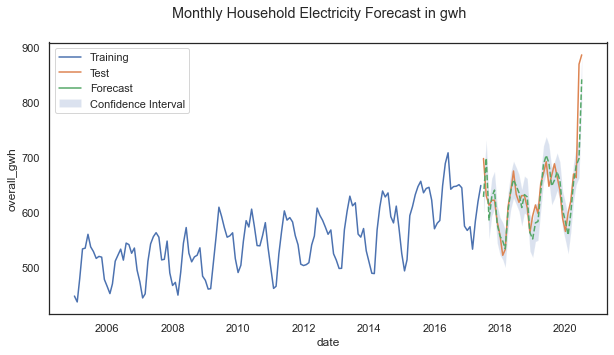

In [46]:
# Plotting the forecasts

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=train.index, y=train['overall_gwh'],ax=ax)
sns.lineplot(x=test.index, y=test['overall_gwh'], ax=ax)
sns.lineplot(x=test.index, y=forecasts_rmse_expand, ax=ax)
ax.fill_between(test.index, conf_int_upper_rmse_expand,conf_int_lower_rmse_expand, alpha=0.2)
plt.legend(["Training", "Test", "Forecast", "Confidence Interval"])
fig.suptitle("Monthly Household Electricity Forecast in gwh")
ax.lines[2].set_linestyle("--")
plt.show()

The plot shows the our forecasts closely follows the test data, which is a good thing. We can now deploy the model to forecast using the entire sample.

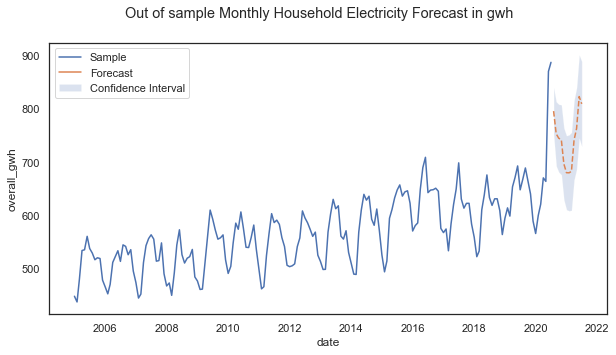

In [47]:
model = SARIMAX(df['overall_gwh'], order=(0,1,3), seasonal_order=(0,1,1,12))
fitted_model = model.fit()
yhat = fitted_model.forecast(12)
yhat_conf = fitted_model.get_forecast(12).conf_int()

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=df.index, y=df['overall_gwh'],ax=ax)
sns.lineplot(x=yhat.index, y=yhat, ax=ax)
ax.fill_between(yhat_conf.index, yhat_conf.iloc[:,0],yhat_conf.iloc[:,1], alpha=0.2)
plt.legend(["Sample", "Forecast", "Confidence Interval"])
fig.suptitle("Out of sample Monthly Household Electricity Forecast in gwh")
ax.lines[1].set_linestyle("--")
plt.show()

The plot shows the next 12 month forecast of household electricity consumption.

## **9. Conclusion**

In this analysis, we explored the [Total Household Electricity Consumption by Dwelling Type](https://data.gov.sg/dataset/total-household-electricity-consumption-by-dwelling-type) dataset from Gov data and developed a **SARIMA model (0,1,3) x (0,1,1)** to forecast monthly household electricity consumption. 

We also note from the exploratory data analysis in section 4:
- Household electricity consumption spiked in mid 2020, most likely due to the COVID restrictions
- Household electricity consumption in private apartments, condos, 4-room and 5-room flats are trending upwards, due to the fact that these types of dwellings are being built more oftern compared to the rest

**Limitations of our analysis:**
- Out-of-sample forecasts may be wildy inaccurate due to the fact that

    - our model residuals do not follow a normal distribution, making it difficult to interpret the confidence interval of forecasts
    - The huge spike in electricity consumption is driven by the COVID restrictions, which are temperory and do not signal a structural trend
    <br>
    <br>
- We assume that household electricity consumption can be modelled by it past values and past errors and did not account for other information that could be relevant, such as monthly average temperature, economic variables etc.

**Further improvements:**

Perhaps we could consider a dynamic regression model to incorporate external variables such as temperature and economic varaibles that could explain electricity consumption. We can also consider using more sophisticated modelling methods such as LSTM, neural networks and bootstrap/bagging methods. 

## **10. References**

- Forecasting Principles and Practice - https://otexts.com/fpp2/
- AutoARIMA - https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html#
- Total Household Electricity Consumption by Dwelling Type - https://data.gov.sg/dataset/total-household-electricity-consumption-by-dwelling-type